In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
titanic_data = pd.read_csv('train.csv')

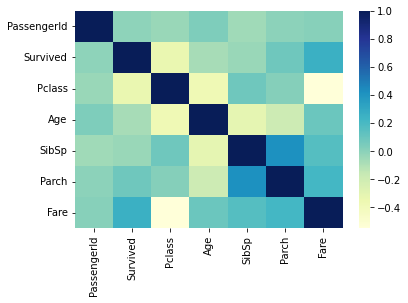

In [9]:
import seaborn as sns
sns.heatmap(titanic_data.corr(),cmap="YlGnBu")
plt.show()

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
split= StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_indices, test_indices in split.split(titanic_data,titanic_data[["Survived","Pclass","Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

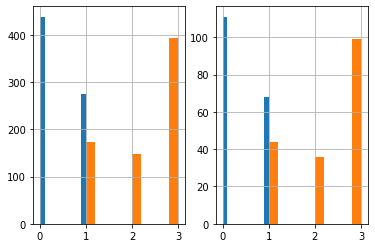

In [14]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()


plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

plt.show()


In [15]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 251 to 281
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          569 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        160 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [16]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator,TransformerMixin):

    def fit(self,X,y=None):
        return self
        
    def transform(self,X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X


In [19]:
from sklearn.preprocessing import OneHotEncoder


class FeatureEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()

        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names = ["C", "S", "Q", "N"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        column_names = ["Female","Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        return X


In [20]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"],axis=1,errors="ignore")

In [21]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer",AgeImputer()),("featureencoder",FeatureEncoder()),("featuredropper",FeatureDropper())])

In [22]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [23]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
251,252,0,3,29.000000,1,1,10.4625,0.0,0.0,1.0,1.0,0.0
275,276,1,1,63.000000,1,0,77.9583,0.0,0.0,1.0,1.0,0.0
514,515,0,3,24.000000,0,0,7.4958,0.0,0.0,1.0,0.0,1.0
669,670,1,1,29.341687,1,0,52.0000,0.0,0.0,1.0,1.0,0.0
202,203,0,3,34.000000,0,0,6.4958,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
853,854,1,1,16.000000,0,1,39.4000,0.0,0.0,1.0,1.0,0.0
335,336,0,3,29.341687,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
860,861,0,3,41.000000,2,0,14.1083,0.0,0.0,1.0,0.0,1.0
594,595,0,2,37.000000,1,0,26.0000,0.0,0.0,1.0,0.0,1.0


In [24]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 251 to 281
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [25]:
from sklearn.preprocessing import StandardScaler
X = strat_train_set.drop(['Survived'],axis=1)
y = strat_train_set['Survived']
scaler = StandardScaler()

X_data = scaler.fit_transform(X)
y_data = y.to_numpy()


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [{"n_estimators": [10, 100, 200, 500],
               "max_depth":[None, 5, 10], "min_samples_split":[2, 3, 4]}]

grid_search = GridSearchCV(clf, param_grid, cv=3,
                           scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [28]:
final_clf = grid_search.best_estimator_

In [29]:
final_clf

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=200)

In [30]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [34]:
X_test = strat_test_set.drop(['Survived'],axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [35]:
final_clf.score(X_data_test,y_data_test)

0.8100558659217877

In [38]:
final_data = pipeline.fit_transform(titanic_data)
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [39]:
X_final = final_data.drop(['Survived'],axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [40]:
prod_clf = RandomForestClassifier()

param_grid = [{"n_estimators": [10, 100, 200, 500],
               "max_depth":[None, 5, 10], "min_samples_split":[2, 3, 4]}]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3,
                           scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [41]:
prod_final_clf = grid_search.best_estimator_


In [42]:
titanic_test_data = pd.read_csv('test.csv')

In [43]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [46]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler=StandardScaler()
X_data_final_test=scaler.fit_transform(X_final_test)

In [49]:
predictions = prod_final_clf.predict(X_data_final_test)

In [48]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions

final_df.to_csv('predictions.csv',index=False)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,